# Laplace Approximation

In [1]:
%%capture
%pip install git+https://github.com/lightning-uq-box/lightning-uq-box.git

## Theoretic Foundation

The Laplace Approximation was originally introduced by [MacKay, 1992](https://authors.library.caltech.edu/13793/1/MACnc92b.pdf). Then, the Laplace Approximation has been adapted to modern neural networks by [Ritter, 2018](https://discovery.ucl.ac.uk/id/eprint/10080902/1/kflaplace.pdf) and [Daxberger, 2021](http://proceedings.mlr.press/v139/daxberger21a/daxberger21a.pdf) and is an approximate Bayesian method. The goal of the Laplace Approximation is to use a second-order Taylor expansion around the fitted MAP estimate and yield a posterior approximation over the model parameters via a full-rank, diagonal or Kronecker-factorized approach. In order for the Laplace Approximation to be computationally feasible for larger network architectures, we use the [Laplace library](https://aleximmer.github.io/Laplace/) to include approaches, such as subnetwork selection that have been for example proposed by [Daxberger, 2021](http://proceedings.mlr.press/v139/daxberger21a/daxberger21a.pdf).

The general idea of the Laplace Approximation to obtain a distribution over the network parameters is to approximate the posterior with a Gaussian distribution centered at the MAP estimate of the parameters [Daxberger, 2021](http://proceedings.mlr.press/v139/daxberger21a/daxberger21a.pdf). In this setting, we define a prior distribution $p(\theta)$ over our network parameters. Because modern neural networks consists of millions of parameters, obtaining a posterior distribution over the weights $\theta$ is intractable. The LA takes MAP estimate of the parameters $\theta_{MAP}$ from a trained network $f_{\theta_{MAP}}(x) = \mu_{\theta_{MAP}}(x)$ and constructs a Gaussian distribution around it. The parameters $\theta_{MAP}$ are obtained by
$$
    \theta_{MAP} = \text{argmin} \mathcal{L}(\theta; D),
$$

where $\mathcal{L}$ is the mean squared error or also referred to as the $\ell^2$ loss, $\mathcal{L}(\theta; \mathcal{D}) := -\sum_{i=1}^n log(p(y_i|f_{\theta}(x_i)))$ and we chose the posterior $p(y_i|f_{\theta}(x_i))$ to be a Gaussian with constant variance $\sigma^2$, such that the loss is the mean squared error and a homoskedastic noise model is assumed. Then with Bayes Theorem, as in  [Daxberger, 2021](http://proceedings.mlr.press/v139/daxberger21a/daxberger21a.pdf), one can relate the posterior to the loss,

$$
    p(\theta|D) = p(D\vert\theta)p(\theta)/p(D)= \frac{1}{Z} exp(- \mathcal{L}(\theta; D)),
$$

with $Z = \int p(D\vert\theta)p(\theta) d\theta$. Now a second-order expansion of $\mathcal{L}$ around $\theta_{MAP}$ is used to construct a Gaussian approximation to the posterior $p(\theta|D)$:

$$
    -\mathcal{L}(\theta; D) \approx -\mathcal{L}(\theta_{MAP}; D)- \frac{1}{2}(\theta-\theta_{MAP}) (\nabla_{\theta}^2 \mathcal{L}(\theta; D)\vert \theta_{MAP}) (\theta-\theta_{MAP}).
$$

The term with the first order derivative is zero as the loss is evaluated at a minimum $\theta_{MAP}$ [Murphy, 2022](https://books.google.de/books?hl=de&lr=&id=OyYuEAAAQBAJ&oi=fnd&pg=PR27&ots=A7kHWDyx-9&sig=pCj6y7c54tW3dleHahn3kdu-JNw#v=onepage&q&f=false), and, further, one assumes that the first term is neglible as the loss is evaluated at $\theta = \theta_{MAP}$. Then taking the expontential of both sides allows to identify, after normalization, the Laplace approximation,

\begin{align*}
p(\theta|D) \approx \mathcal{N}(\theta_{MAP}, \Sigma) && \text{with} \qquad \Sigma =  (\nabla_{\theta}^2 \mathcal{L}(\theta; D)\vert \theta_{MAP})^{-1}.
\end{align*}


As the covariance is just the inverse Hessian of the loss, with $\theta_{MAP}\in \mathcal{R}^W$ and $H^{-1}\in \mathcal{R}^{W\times W}$, with $W$ being the number of weights, we get the posterior distribution

$$
    p(\theta|D)\approx \mathcal{N}(\theta_{MAP}, H^{-1}).
$$

The computation of the Hessian term is still expensive. Therefore, further approximations are introduced in practice, most commonly the Generalized Gauss-Newton matrix \cite{martens2020new}. This takes the following form:
$$
    H \approx \widetilde{H}=\sum_{n=1}^NJ_n^TH_nJ_n,
$$
where $J_n\in \mathcal{R}^{O\times W}$ is the Jacobian of the model outputs with respect to the parameters $\theta$ and $H_n\in\mathcal{R}^{O\times O}$ is the Hessian of the negative log-likelihood with respect to the model outputs, where $O$ denotes the model output size and $W$ the number of parameters. 

During prediction we cannot compute the full posterior predictive distribution but instead resort to approximations. One strategy is to do sampling $\theta_s \sim p(\theta|D)$ for $s \in \{1, ...,S\}$ to approximate the predictions, however, [Immer et al. 2021](https://arxiv.org/abs/2008.08400) suggested that a linearization of the form $f_{\theta}(x)=f_{\theta_{MAP}}(x)+ J_{\theta_{MAP}}(\theta-\theta_{MAP})$ works better in practice and this is also the default in the [Laplace library](https://aleximmer.github.io/Laplace/).

$$
    \hat{y}(x^{\star}) = \frac{1}{S} \sum_{s=1}^S f_{\theta_s}(x^{\star}),
$$

and obtain the predictive uncertainty by

$$
    \sigma^2(x^{\star}) = \sqrt{\frac{1}{S} \sum_{s=1}^S f_{\theta_s}(x^{\star})^2 - \hat{y}(x^{\star})^2+\sigma^2}.
$$

The implementation is a wrapper around a model from the fantastic [Laplace library](https://aleximmer.github.io/Laplace/) so all the available options for subnet strategies can be found in their docs.

## Imports

In [2]:
import os
import tempfile
from functools import partial

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from laplace import Laplace
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger

from lightning_uq_box.datamodules import ToyHeteroscedasticDatamodule
from lightning_uq_box.models import MLP
from lightning_uq_box.uq_methods import DeterministicRegression, LaplaceRegression
from lightning_uq_box.viz_utils import (
    plot_calibration_uq_toolbox,
    plot_predictions_regression,
    plot_toy_regression_data,
    plot_training_metrics,
)

plt.rcParams["figure.figsize"] = [14, 5]

/opt/anaconda3/envs/uqEnv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
seed_everything(0)  # seed everything for reproducibility

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0


0

We define a temporary directory to look at some training metrics and results.

In [4]:
my_temp_dir = tempfile.mkdtemp()

## Datamodule

To demonstrate the method, we will make use of a Toy Regression Example that is defined as a [Lightning Datamodule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html). While this might seem like overkill for a small toy problem, we think it is more helpful how the individual pieces of the library fit together so you can train models on more complex tasks.

In [5]:
dm = ToyHeteroscedasticDatamodule()

X_train, Y_train, train_loader, X_test, Y_test, test_loader, X_gtext, Y_gtext = (
    dm.X_train,
    dm.Y_train,
    dm.train_dataloader(),
    dm.X_test,
    dm.Y_test,
    dm.test_dataloader(),
    dm.X_gtext,
    dm.Y_gtext,
)

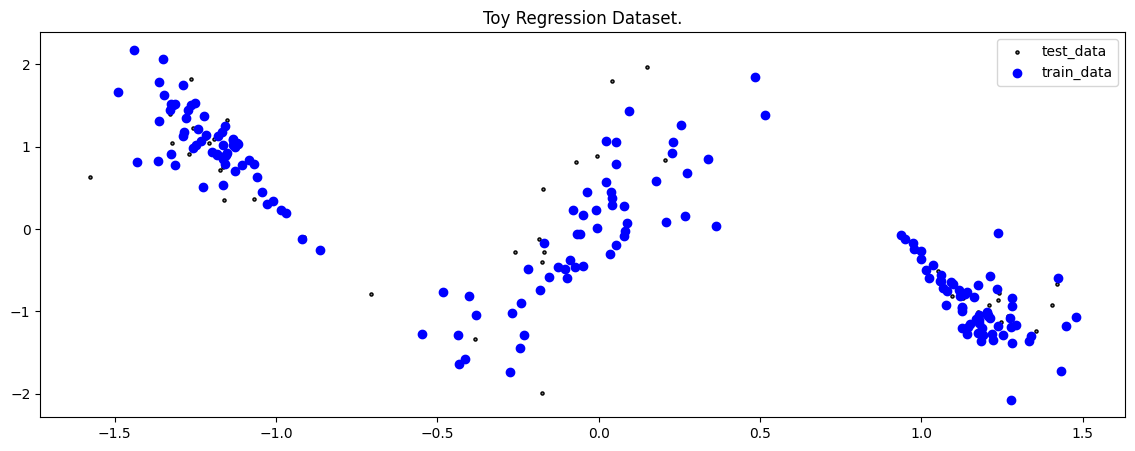

In [6]:
fig = plot_toy_regression_data(X_train, Y_train, X_test, Y_test)

## Model

For our Toy Regression problem, we will use a simple Multi-layer Perceptron (MLP) that you can configure to your needs. For the documentation of the MLP see [here](https://readthedocs.io/en/stable/api/models.html#MLP).

In [7]:
network = MLP(n_inputs=1, n_hidden=[50, 50], n_outputs=1, activation_fn=nn.Tanh())
network

MLP(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=50, out_features=1, bias=True)
  )
)

For the Laplace model, we first train a plain deterministic model to obtain a MAP estimate of the weights via the standard MSE loss. Subsequently, we fit the Laplace Approximation to obtain an estimate of the epistemic uncertainty for predictions.

In [8]:
deterministic_model = DeterministicRegression(
    model=network,
    optimizer=partial(torch.optim.Adam, lr=1e-2),
    loss_fn=torch.nn.MSELoss(),
)

## Trainer

Now that we have a LightningDataModule and base model, we can conduct training with a [Lightning Trainer](https://lightning.ai/docs/pytorch/stable/common/trainer.html). It has tons of options to make your life easier, so we encourage you to check the documentation.

In [9]:
logger = CSVLogger(my_temp_dir)
trainer = Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=100,  # number of epochs we want to train
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=1,
    enable_checkpointing=False,
    enable_progress_bar=False,
)

/opt/anaconda3/envs/uqEnv/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/anaconda3/envs/uqEnv/lib/python3.12/site-packag ...
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Training our model is now easy:

In [10]:
trainer.fit(deterministic_model, dm)

/opt/anaconda3/envs/uqEnv/lib/python3.12/site-packages/torch/__init__.py:1551: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return _C._get_float32_matmul_precision()
INFO: You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_flo

## Training Metrics

To get some insights into how the training went, we can use the utility function to plot the training loss and RMSE metric.

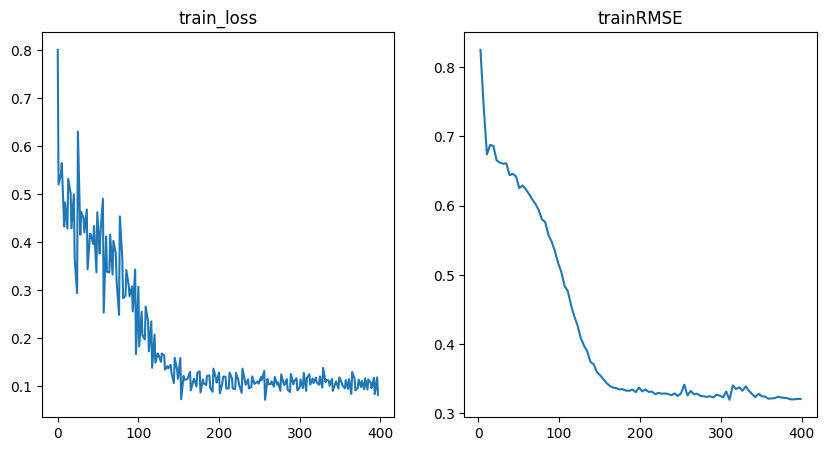

In [11]:
fig = plot_training_metrics(
    os.path.join(my_temp_dir, "lightning_logs"), ["train_loss", "trainRMSE"]
)

## Fit Laplace
We will utilize the great [Laplace Library](https://aleximmer.github.io/Laplace/) that allows you to define different flavors of Laplace approximations. For small networks like in this example, one can fit the Laplace approximation over all weights, but this is not feasible for large million-parameter networks. In those cases, on can resort to a "last-layer" approximation, where only the last layer weights are stochastic, while all other weights are deterministic. This behavior is controlled with the `subset_of_weights` parameter. This is chosen in combination with the structure of the Hessian that is fitted, see the `hessian_structure` parameter. Check their documentation for details. The Lightning-UQ-Box provides a wrapper so that the workflow is the same as with any other implemented UQ-Method.

One can also tune the prior precision and or sigma noise values after the Laplace fitting procedure with the argument `tune_prior_precision=True` and `tune_sigma_noise=True` otherwise, the prediction will rely on the default `sigma_noise` values passed to the Laplace class for an estimate of aleatoric uncertainty under a homoscedastic noise assumption. For a related discussion one can look at [this GitHub issue](https://github.com/aleximmer/Laplace/issues/142).

In [12]:
la = Laplace(
    deterministic_model.model,
    "regression",
    subset_of_weights="last_layer",
    hessian_structure="full",
    sigma_noise=0.4,
)


laplace_model = LaplaceRegression(laplace_model=la, tune_prior_precision=True)

trainer = Trainer(default_root_dir=my_temp_dir)

INFO: Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:lightning.pytorch.utilities.rank_zero:Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/opt/anaconda3/envs/uqEnv/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/anaconda3/envs/uqEnv/lib/python3.12/site-packag ...
INFO: 💡 Tip: For seamless cloud uploads and vers

## Prediction

For prediction we can either rely on the `trainer.test()` method or manually conduct a `predict_step()`. Using the trainer will save the predictions and some metrics to a CSV file, while the manual `predict_step()` with a single input tensor will generate a dictionary that holds the mean prediction as well as some other quantities of interest, for example the predicted standard deviation or quantile. The Laplace wrapper module will conduct the Laplace fitting procedure automatically before making the first prediction and will use it for any subsequent call. Originally, this was done through sampling and multiple forward passes, however, [Immer et al. 2021](https://arxiv.org/abs/2008.08400) showed that a linearization of the model achieves better performance in practice:
$f_{\theta}(x)=f_{\theta_{MAP}}(x)+ J_{\theta_{MAP}}(\theta-\theta_{MAP})$
and that is the current default implementation. However, arguments can be passed to the class or the individual predict step to choose between the following procedures of sampling as `pred_type="glm"` (linearization) or `pred_type="nn"` (sampling).

In [13]:
trainer.test(laplace_model, dm)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/opt/anaconda3/envs/uqEnv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 83.09it/s, neg_marglik=75.84266662597656]

Testing: |          | 0/? [00:00<?, ?it/s]

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.35it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         testMAE            0.3344504237174988
         testR2             0.7423638701438904
        testRMSE            0.5086640119552612
        test_loss           0.25873905420303345
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.25873905420303345,
  'testMAE': 0.3344504237174988,
  'testR2': 0.7423638701438904,
  'testRMSE': 0.5086640119552612}]

## Evaluate Predictions

The constructed Data Module contains two possible test variable. `X_test` are IID samples from the same noise distribution as the training data, while `X_gtext` ("X ground truth extended") are dense inputs from the underlying "ground truth" function without any noise that also extends the input range to either side, so we can visualize the method's UQ tendencies when extrapolating beyond the training data range. Thus, we will use `X_gtext` for visualization purposes, but use `X_test` to compute uncertainty and calibration metrics because we want to analyse how well the method has learned the noisy data distribution.

In [14]:
preds = laplace_model.predict_step(X_gtext)

fig = plot_predictions_regression(
    X_train,
    Y_train,
    X_gtext,
    Y_gtext,
    preds["pred"],
    preds["pred_uct"],
    epistemic=preds["epistemic_uct"],
    aleatoric=preds["aleatoric_uct"],
    title="Laplace Approximation",
)

RuntimeError: Expected all tensors to be on the same device, but got mat1 is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA_addmm)

For some additional metrics relevant to UQ, we can use the great [uncertainty-toolbox](https://uncertainty-toolbox.github.io/) that gives us some insight into the calibration of our prediction. For a discussion of why this is important, see ...

In [ ]:
preds = laplace_model.predict_step(X_test)
fig = plot_calibration_uq_toolbox(
    preds["pred"].cpu().numpy(),
    preds["pred_uct"].numpy(),
    Y_test.cpu().numpy(),
    X_test.cpu().numpy(),
)

## Additional Resources

[Daxberger et al. 2020](https://arxiv.org/abs/2010.14689) introduced a subnetwork selection strategy that turns selected weights "Bayesian" while keeping the rest of the network deterministic and show performance on par with deep ensembles.